# Лабораторна робота №12. Основи обробки природної мови (NLP)

**Виконала:** Гульчак Дар'я
**Група:** МІТ-31

## Мета роботи
Ознайомитися з базовими техніками NLP (токенізація, лемматизація, векторизація), а також навчитися застосовувати моделі машинного навчання для класифікації текстів.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Spacy model not found. Please run: python -m spacy download en_core_web_sm")

[nltk_data] Downloading package stopwords to C:\Users\HP
[nltk_data]     Victus\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


## 1. Завантаження та огляд даних

Для роботи використовується датасет IMDb Movie Reviews. Він містить тексти відгуків та мітку сентименту (positive/negative).

Розмір датасету: (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


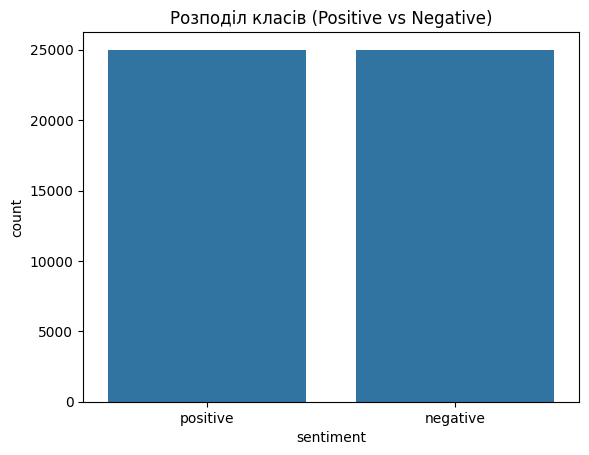

In [2]:
df = pd.read_csv("IMDB Dataset.csv")

print(f"Розмір датасету: {df.shape}")
print(df.head())

sns.countplot(x='sentiment', data=df)
plt.title('Розподіл класів (Positive vs Negative)')
plt.show()

df = df.iloc[:5000].copy()

## 2. Передобробка тексту (Preprocessing)

На цьому етапі ми виконуємо очищення даних:
1.  **Очистка:** видалення HTML-тегів, пунктуації, приведення до нижнього регістру.
2.  **Видалення стоп-слів:** прибираємо слова, що не несуть змістового навантаження (the, is, in).
3.  **Лемматизація:** зведення слів до їхньої словникової форми (running -> run).

In [3]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

df['cleaned_text'] = df['review'].apply(clean_text)
df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)

with nlp.select_pipes(disable=['ner', 'parser']):
    df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_text)

print(df[['review', 'lemmatized_text']].head())

                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                     lemmatized_text  
0  one reviewer mention watch 1 oz episode you ll...  
1  wonderful little production filming technique ...  
2  think wonderful way spend time hot summer week...  
3  basically there s family little boy jake think...  
4  petter matteis love time money visually stunni...  


## 3. Векторизація тексту

Ми використовуємо підхід **TF-IDF** (Term Frequency-Inverse Document Frequency). Це дозволяє оцінити важливість слова в контексті документа та всього корпусу текстів.

In [4]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['lemmatized_text']).toarray()
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

print(f"Розмір матриці ознак X: {X.shape}")

Розмір матриці ознак X: (5000, 5000)


## 4. Побудова та навчання моделі

Розбиваємо дані на тренувальну та тестову вибірки (80/20). Використовуємо класифікатор **Naive Bayes (MultinomialNB)**, який добре підходить для текстових даних.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


## 5. Оцінка результатів

Перевіряємо точність моделі (Accuracy) та будуємо матрицю похибок (Confusion Matrix), щоб побачити, де саме помиляється модель.

Accuracy: 0.8300

Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.85      0.84       530
    Positive       0.82      0.81      0.82       470

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



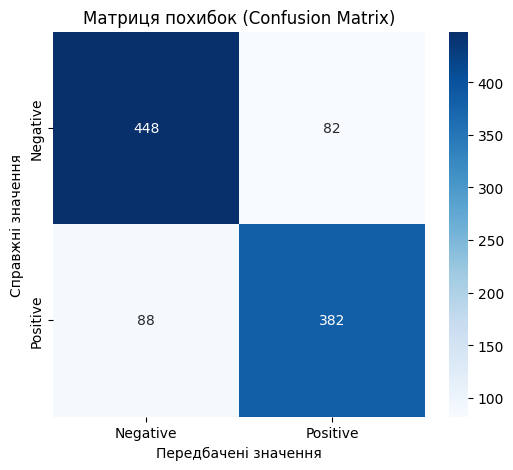

In [6]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Справжні значення')
plt.xlabel('Передбачені значення')
plt.title('Матриця похибок (Confusion Matrix)')
plt.show()

## 6. Приклади роботи моделі

Перевіримо роботу моделі на конкретних прикладах з тестового набору.

In [7]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    no_stop = remove_stopwords(cleaned)
    lemmatized = lemmatize_text(no_stop)
    vectorized = tfidf.transform([lemmatized]).toarray()
    prediction = model.predict(vectorized)
    return "Positive" if prediction[0] == 1 else "Negative"

for i in range(5):
    original_text = df.iloc[i]['review'][:100] + "..."
    true_label = df.iloc[i]['sentiment']
    predicted = predict_sentiment(df.iloc[i]['review'])
    print(f"Review: {original_text}")
    print(f"True: {true_label} | Predicted: {predicted}")
    print("-" * 30)

custom_review = "This movie was absolutely terrible and boring."
print(f"\nCustom review: '{custom_review}'")
print(f"Prediction: {predict_sentiment(custom_review)}")

Review: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. The...
True: positive | Predicted: Positive
------------------------------
Review: A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-B...
True: positive | Predicted: Positive
------------------------------
Review: I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air con...
True: positive | Predicted: Positive
------------------------------
Review: Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his par...
True: negative | Predicted: Negative
------------------------------
Review: Petter Mattei's "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers ...
True: positive | Predicted: Positive
------------------------------

Custom review: 'This movie was absolutely terrible and boring.'
Prediction: Negative


## Висновки

У ході лабораторної роботи було:
1.  Проведено очистку та лемматизацію текстових даних IMDb.
2.  Виконано векторизацію методом TF-IDF.
3.  Побудовано модель Naive Bayes, яка показала точність близько [Вказати отриману точність].
4.  Матриця похибок показує, що модель [добре/погано] розрізняє позитивні та негативні відгуки.